In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
import re

In [2]:
class OrderParameter:

    # name should be unique to the Order Parameter being defined
    # In other words for every possible pair of OP's x and y, (x.name != y.name) must be true
    def __init__(self, name, traj):
        self.name = name
        self.traj = traj
        
    def __eq__(self, other):
        return self.name == other.name
    
    def __hash__(self):
        return hash(self.name)
        
    def __str__(self):
        return str(self.name)

In [3]:
def distortion(centers, ops, mut):
    dis = 0.0
    for i in ops:
        min_val = np.inf
        for j in centers:
            tmp = mut.iqr(i, j)
            if tmp < min_val:
                min_val = tmp
        dis = dis + (min_val * min_val)
    return 1 + (dis ** (0.5))

In [4]:
def arithmetic_mean(centers, ops, mut):
    mean = 0.0
    for i in ops:
        min_val = np.inf
        for j in centers:
            tmp = mut.iqr(i, j)
            if tmp < min_val:
                min_val = tmp
        mean = mean + min_val
    return (mean / (len(ops)))

In [5]:
def geometric_mean(centers, ops, mut):
    mean = 1.0
    for i in ops:
        min_val = np.inf
        for j in centers:
            tmp = mut.iqr(i, j)
            if tmp < min_val:
                min_val = tmp
        mean = mean * (min_val ** (1.0 / len(ops)))
    return mean

In [6]:
class DissimilarityMatrix:

    def __init__(self, max_OPs, mut):
        self.max_OPs = max_OPs
        self.matrix = [[] for i in range(max_OPs)]
        self.mut = mut
        self.OPs = []

    def add_OP(self, OP):
        if len(self.OPs) == self.max_OPs:
            mut_info = []
            existing = []
            for i in range(len(self.OPs)):
                mut_info.append(self.mut.iqr(self.OPs[i], OP))
                product = 1
                for j in range(len(self.OPs)):
                    if not i == j:
                        product = product * self.matrix[i][j]
                existing.append(product)
            update = False
            difference = None
            for i in range(len(self.OPs)):
                candidate_info = 1
                for j in range(len(self.OPs)):
                    if not i == j:
                        candidate_info = candidate_info * mut_info[j]
                if candidate_info > existing[i]:
                    update = True
                    if difference == None:
                        difference = candidate_info - existing[i]
                        old_OP = i
                    else:
                        if (candidate_info - existing[i]) > difference:
                            difference = candidate_info - existing[i]
                            old_OP = i
            if update == True:
                mut_info[old_OP] = self.mut.iqr(OP, OP)
                self.matrix[old_OP] = mut_info
                self.OPs[old_OP] = OP
                for i in range(len(self.OPs)):
                    self.matrix[i][old_OP] = mut_info[i]
        else:
            for i in range(len(self.OPs)):
                mut_info = self.mut.iqr(OP, self.OPs[i])
                self.matrix[i].append(mut_info)
                self.matrix[len(self.OPs)].append(mut_info)
            self.matrix[len(self.OPs)].append(self.mut.iqr(OP, OP))
            self.OPs.append(OP)
        
    def reduce(self):
        min_val = 10
        index = -1
        for i in range(len(self.matrix)):
            product = 1
            for j in range(len(self.matrix[i])):
                if not i == j:
                    product = product * self.matrix[i][j]
            if product < min_val:
                index = i
                min_val = product
        self.matrix.pop(index)
        for i in range(len(self.matrix)):
            self.matrix[i].pop(index)
        self.OPs.pop(index)
        
    def min_product(self):
        min_val = 10
        for i in range(len(self.matrix)):
            product = 1
            for j in range(len(self.matrix[i])):
                if not i == j:
                    product = product * self.matrix[i][j]
            if product < min_val:
                min_val = product
        return min_val
    
    def get_OPs(self):
        return self.OPs
    
    def __str__(self):
        output = ""
        output = output + "OPs:\n"
        for i in self.OPs:
            output = output + str(i) + "\n"
        output = output + "\nMatrix:\n"
        for i in self.matrix:
            for j in i:
                output = output + str(j) + " "
            output = output + "\n"
        return output
                

In [7]:
def d1_bin(x, bins = 80):

    min_val = np.amin(x)
    max_val = np.amax(x)
    span = max_val - min_val

    p_x = [0.0 for i in range(bins)]

    for i in x:
        bin_num = (int) (bins * (i - min_val) / span)
        if bin_num == bins:
            bin_num -= 1
        p_x[bin_num] += 1.0 / len(x)

    return p_x

In [8]:
def d2_bin(x, y, bins = 80):

    if len(x) != len(y):
        raise Exception("Order parameter lists are of different size.")

    min_x = np.amin(x)
    max_x = np.amax(x)
    span_x = max_x - min_x

    min_y = np.amin(y)
    max_y = np.amax(y)
    span_y = max_y - min_y

    p_xy = [[0.0 for i in range(bins)] for j in range(bins)]

    for i in range(len(x)):
        bin_x = (int) (bins * (x[i] - min_x) / span_x)
        bin_y = (int) (bins * (y[i] - min_y) / span_y)
        if bin_x == bins:
            bin_x -= 1
        if bin_y == bins:
            bin_y -= 1
        p_xy[bin_x][bin_y] += 1.0 / len(x)

    return p_xy

In [9]:
class Memoizer:
    
    def __init__(self):
        self.memo = {}
        self.bins = 80
        
    def iqr(self, OP1, OP2):
        index = str(OP1.name) + " " + str(OP2.name)
        if index in self.memo:
            return self.memo[index]
        else:
            x = OP1.traj
            y = OP2.traj
            p_x = d1_bin(x, self.bins)
            p_y = d1_bin(y, self.bins)
            p_xy = d2_bin(x, y, self.bins)

            info = 0
            entropy = 0

            for i in range(len(p_x)):
                for j in range(len(p_y)):
                    if p_xy[i][j] != 0:
                        entropy -= p_xy[i][j] * np.log(p_xy[i][j])
                        info += p_xy[i][j] * np.log(p_xy[i][j] / (p_x[i] * p_y[j]))

            if ((1 - (info / entropy)) < 0):
                output = 0.0
            else:
                output = (1 - (info / entropy))
            self.memo[index] = output
            return output
    
    def __str__(self):
        print(len(self.memo))

In [10]:
def grouping(new_OPs, all_OPs, mut):
    groups = [[] for i in range(len(new_OPs))]
    for OP in all_OPs:
        group = 0
        for i in range(len(new_OPs)):
            tmp = mut.iqr(OP, new_OPs[i])
            if tmp < mut.iqr(OP, new_OPs[group]):
                group = i
        groups[group].append(OP)
    return groups

In [11]:
def group_evaluation(OPs, mut):
    
    center = OPs[0]
    min_distortion = distortion([OPs[0]], OPs, mut)
    
    for i in OPs:
        tmp = distortion([i], OPs, mut)
        if tmp < min_distortion:
            center = i
            min_distortion = tmp

    return center

In [12]:
def cluster(ops, seeds, mut):
    
    old_centers = []
    centers = copy.deepcopy(seeds)
    
    while (set(centers) != set(old_centers)):
        
        old_centers = copy.deepcopy(centers)
        centers = []
        groups = grouping(old_centers, ops, mut)
        
        for i in range(len(groups)):
            result = group_evaluation(groups[i], mut)
            centers.append(result)

    return centers


In [23]:
def find_ops(old_ops, max_outputs):
    
    mut = Memoizer()
    matrix = DissimilarityMatrix(max_outputs, mut)
    
    for i in old_ops:
        matrix.add_OP(i)
        
    for i in old_ops[::-1]:
        matrix.add_OP(i)
    
    tmp = copy.deepcopy(matrix)
    distortion_array = []
    num_array = []
    str_num_array = []

    while (len(tmp.OPs) > 0):
        num_array.append(len(tmp.OPs))
        str_num_array.append(str(len(tmp.OPs)))
        seed = []
        for i in tmp.OPs:
            seed.append(i)
        tmp_ops = cluster(old_ops, seed, mut)
        distortion_array.append(distortion(tmp_ops, old_ops, mut))
        tmp.reduce()
    
    plt.plot(str_num_array, distortion_array)
    plt.xlabel("Number of OPs")
    plt.ylabel("Distortion")
    plt.show()
    
    jumps = []
    
    for dim in range(1,6):
        neg_expo = np.array(distortion_array) ** (-0.5 * dim)
        plt.plot(str_num_array, neg_expo, label=str(-0.5 * dim))
        local = []
        for j in range(len(neg_expo) - 1):
            local.append(neg_expo[j] - neg_expo[j + 1])
        jumps.append(local)
    
    plt.xlabel("Number of Order Parameters")
    plt.ylabel("Distortion with Neg. Expo")
    plt.legend()
    plt.show()
    
    jump_num_array = []
    for i in range(len(str_num_array) - 1):
        jump_num_array.append(str_num_array[i])
        
    for i in range(len(jumps)):
        plt.plot(jump_num_array, jumps[i], label=str(-0.5 * (i + 1)))
        
    plt.xlabel("Number of Order Parameters")
    plt.ylabel("Jump in Distortion with Neg. Expo")
    plt.legend()
    plt.show()
    
    neg_expo = np.array(distortion_array) ** (-0.5)
    
    jumps = []
    
    for i in range(len(neg_expo) - 1):
        jumps.append(neg_expo[i] - neg_expo[i + 1])
    
    min_index = 0
    for i in range(len(jumps)):
        if jumps[i] > jumps[min_index]:
            min_index = i
    
    while (len(matrix.OPs) > num_array[min_index]):
        matrix.reduce()
        
    return cluster(old_ops, matrix.OPs, mut)


In [14]:
def find_wells(prob):

    energy = []
    for i in (range(len(prob))):
        if prob[i] == 0:
            energy.append(np.inf)
        else:
            energy.append(-1 * np.log(prob[i]))

    wells = 0
    max = np.inf
    min = np.inf
    d = 1
    i = 0
    for x in energy:
        if x > max:
            max = x
            if (max - min > 1):
                min = x
                d = 1
        elif x < min:
            min = x
            if (max - min > 1):
                if d == 1:
                    wells = wells + 1
                max = x
                d = -1
        i = i + 1

    return wells

In [15]:
colvar = open("data/BOUND_COLVAR")
split = colvar.readline().split()
names = []
trajs = {}

for i in range(3, len(split)):
    names.append(split[i])
    trajs[split[i]] = []
    
for line in colvar:
    timestep = line.split()
    for i in range(len(timestep) - 1):
        trajs[names[i]].append(float(timestep[i + 1]))

all_ops = []
filter_ops = []
    
for i in names:
    if find_wells(d1_bin(trajs[i], bins=20)) > 1:
        filter_ops.append(OrderParameter(i, trajs[i]))

125


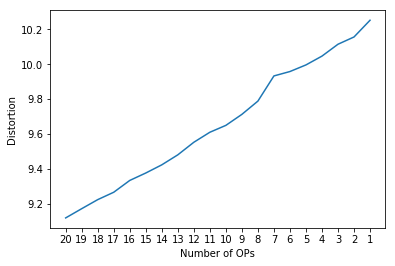

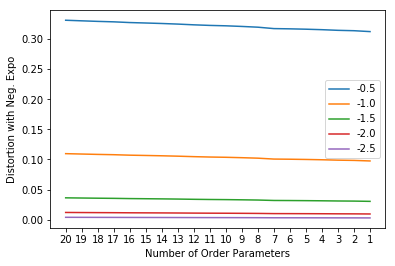

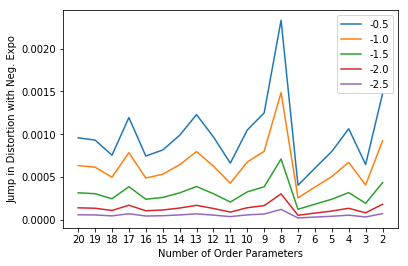

d564_1665
d1353_1665
d890_1664
d1076_1664
d134_1666
d1412_1666
d1076_1665
d855_1665


'filename = str(counter) + "bin.dat"\nf = open(filename, "w+")\n    \ndis_array = []\nfor i in final_filter_ops:\n    dis_array.append(i.name)\n    x = re.search("d(\\d+)_(\\d+)", i.name)\n    f.write(i.name + ": DISTANCE ATOMS=" + x.group(1) + "," + x.group(2) + "\n")\n    \nf.write("PRINT ARG=")\nfor i in range(len(dis_array)):\n    f.write(dis_array[i])\n    if i < (len(dis_array) - 1):\n        f.write(",")\nf.write(" FILE=" + str(counter) + "COLVAR")\nf.close()'

In [24]:
print(len(filter_ops))

final_filter_ops = find_ops(filter_ops, 20)

for i in final_filter_ops:
    print(i)

'''filename = str(counter) + "bin.dat"
f = open(filename, "w+")
    
dis_array = []
for i in final_filter_ops:
    dis_array.append(i.name)
    x = re.search("d(\d+)_(\d+)", i.name)
    f.write(i.name + ": DISTANCE ATOMS=" + x.group(1) + "," + x.group(2) + "\n")
    
f.write("PRINT ARG=")
for i in range(len(dis_array)):
    f.write(dis_array[i])
    if i < (len(dis_array) - 1):
        f.write(",")
f.write(" FILE=" + str(counter) + "COLVAR")
f.close()'''

0.8651122082674663


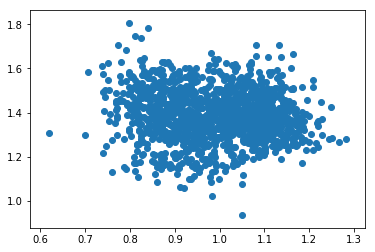

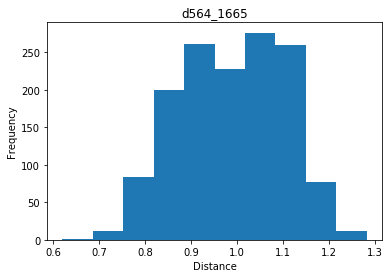

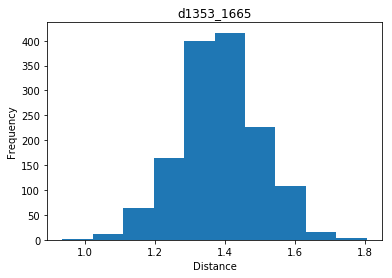

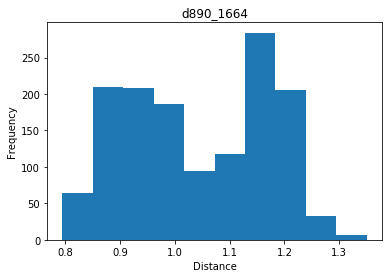

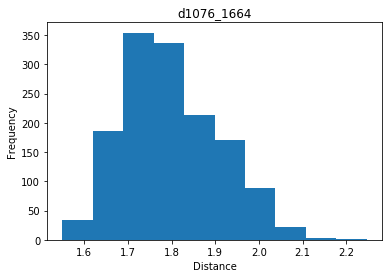

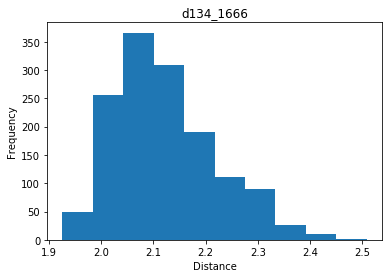

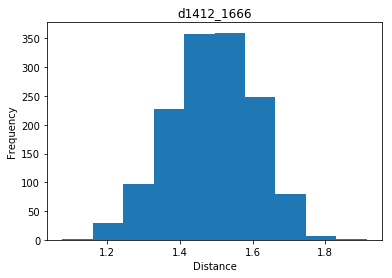

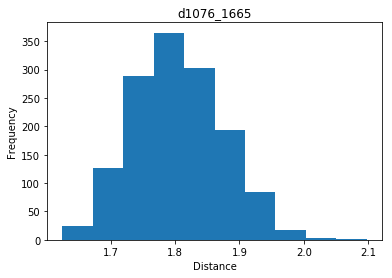

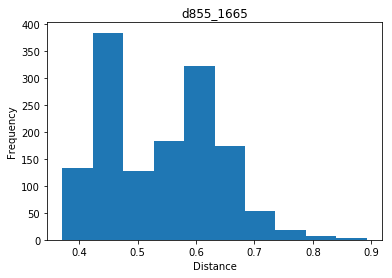

In [17]:
memo = Memoizer()
print(memo.iqr(final_filter_ops[0], final_filter_ops[1]))

plt.scatter(final_filter_ops[0].traj, final_filter_ops[1].traj)
plt.show()

for OP in final_filter_ops:
    plt.hist(OP.traj, bins=10)
    plt.title(OP.name)
    plt.xlabel("Distance")
    plt.ylabel("Frequency")
    plt.show()

In [18]:
'''final_all_ops = find_ops(all_ops, 30)

print("All Order Parameters: " + str(len(all_ops)))
for i in final_all_ops:
    print(i.name)'''

'final_all_ops = find_ops(all_ops, 30)\n\nprint("All Order Parameters: " + str(len(all_ops)))\nfor i in final_all_ops:\n    print(i.name)'

In [19]:
'''for OP in final_all_ops:
    plt.hist(OP.traj)
    plt.title(OP.name)
    plt.xlabel("Distance")
    plt.ylabel("Frequency")
    plt.show()'''

'for OP in final_all_ops:\n    plt.hist(OP.traj)\n    plt.title(OP.name)\n    plt.xlabel("Distance")\n    plt.ylabel("Frequency")\n    plt.show()'

In [20]:
'''
Results with 1 + distortion
All Order Parameters: 428
d921_1665
d1076_1665
Filtered Order Parameters: 204
d1201_1665
d575_1665
d921_1665
'''

'\nResults with 1 + distortion\nAll Order Parameters: 428\nd921_1665\nd1076_1665\nFiltered Order Parameters: 204\nd1201_1665\nd575_1665\nd921_1665\n'